In [50]:
pip install pandas numpy joblib datamol rdkit scikit-learn xgboost lightgbm catboost ngboost seaborn chemplot umap-learn shap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import warnings
import joblib
import pandas as pd
import numpy as np
import datamol as dm
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, AllChem
from sklearn.model_selection import train_test_split, ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [13]:
def remove_zero_variance_features(data):
    selector = VarianceThreshold()
    selector.fit(data)
    retained_columns =  data.columns[selector.get_support()]
    dropped_columns =  data.columns[~selector.get_support()]
    print(f"{len(dropped_columns)} columns dropped because of zero variance features: {dropped_columns.tolist()}")
    return data[retained_columns]

def remove_collinear_features(data, threshold):
    corr_matrix = data.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"{len(to_drop)} columns dropped because of correlation greater than {threshold}: {to_drop}")
    return data.drop(columns=to_drop, axis=1, inplace=False)

def scale_features_standard(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

def scale_features_minmax(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

def scale_targets_standard(data):
    scaler = StandardScaler()
    data_array = data.values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(data_array)
    return pd.DataFrame(scaled_data, columns=[data.columns]), scaler

def scale_targets_minmax(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_array = data.values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(data_array)
    return pd.DataFrame(scaled_data, columns=[data.columns]), scaler

In [23]:
df_X1_reactant = pd.read_csv('reactantfeats_morfeusdesc.csv', index_col=False)
df_X1_ts = pd.read_csv('tsfeats_morfeusdesc.csv', index_col=False)
df_X1_product = pd.read_csv('productfeats_morfeusdesc.csv', index_col=False)

df_X2_reactant = pd.read_csv('reactantfeats_mordreddesc.csv', usecols=['Datapoint','TPSA','PEOE_VSA1','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','SMR_VSA1','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','SlogP_VSA10','SlogP_VSA11','EState_VSA1','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','EState_VSA10','VSA_EState1','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9'], index_col=False)
df_X2_ts = pd.read_csv('tsfeats_mordreddesc.csv', usecols=['Datapoint','TPSA','PEOE_VSA1','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','SMR_VSA1','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','SlogP_VSA10','SlogP_VSA11','EState_VSA1','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','EState_VSA10','VSA_EState1','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9'], index_col=False)
df_X2_product = pd.read_csv('productfeats_mordreddesc.csv', usecols=['Datapoint','TPSA','PEOE_VSA1','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','SMR_VSA1','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','SlogP_VSA10','SlogP_VSA11','EState_VSA1','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','EState_VSA10','VSA_EState1','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9'], index_col=False)

df_X3_reactant = pd.read_csv('wrtprecomplex_pm7.csv', usecols=['Datapoint', 'eR', 'GR', 'HR', 'freqR', 'irR', 'dipoleR', 'homoR', 'lumoR', 'qhirshR', 'etaR', 'alphaR'], index_col=False)
df_X3_ts = pd.read_csv('wrtprecomplex_pm7.csv', usecols=['Datapoint', 'eTS', 'GTS', 'HTS', 'freqTS', 'irTS', 'dipoleTS', 'homoTS', 'lumoTS', 'qhirshTS', 'etaTS', 'alphaTS'], index_col=False)
df_X3_product = pd.read_csv('wrtprecomplex_pm7.csv', usecols=['Datapoint', 'eP', 'GP', 'HP', 'freqP', 'irP', 'dipoleP', 'homoP', 'lumoP', 'qhirshP', 'etaP', 'alphaP'], index_col=False)
df_X3_reactant.rename(columns={'eR': 'e_PM7', 'GR': 'G_PM7', 'HR': 'H_PM7', 'freqR': 'freq_PM7', 'irR': 'ir_PM7', 'dipoleR': 'dipole_PM7', 'homoR': 'homo_PM7', 'lumoR': 'lumo_PM7', 'qhirshR': 'qhirsh_PM7', 'etaR': 'eta_PM7', 'alphaR': 'alpha_PM7'}, inplace=True)
df_X3_ts.rename(columns={'eTS': 'e_PM7', 'GTS': 'G_PM7', 'HTS': 'H_PM7', 'freqTS': 'freq_PM7', 'irTS': 'ir_PM7', 'dipoleTS': 'dipole_PM7', 'homoTS': 'homo_PM7', 'lumoTS': 'lumo_PM7', 'qhirshTS': 'qhirsh_PM7', 'etaTS': 'eta_PM7', 'alphaTS': 'alpha_PM7'}, inplace=True)
df_X3_product.rename(columns={'eP': 'e_PM7', 'GP': 'G_PM7', 'HP': 'H_PM7', 'freqP': 'freq_PM7', 'irP': 'ir_PM7', 'dipoleP': 'dipole_PM7', 'homoP': 'homo_PM7', 'lumoP': 'lumo_PM7', 'qhirshP': 'qhirsh_PM7', 'etaP': 'eta_PM7', 'alphaP': 'alpha_PM7'}, inplace=True)

# Merge Dataframes of various features
df_X_reactant = pd.merge(df_X1_reactant, df_X3_reactant, on='Datapoint', how='inner')
df_X_ts = pd.merge(df_X1_ts, df_X3_ts, on='Datapoint', how='inner')
df_X_product = pd.merge(df_X1_product, df_X3_product, on='Datapoint', how='inner')
#df_Xtmp_reactant = pd.merge(df_X1_reactant, df_X2_reactant, on='Datapoint', how='inner')
#df_Xtmp_ts = pd.merge(df_X1_ts, df_X2_ts, on='Datapoint', how='inner')
#df_Xtmp_product = pd.merge(df_X1_product, df_X2_product, on='Datapoint', how='inner')
#df_X_reactant = pd.merge(df_Xtmp_reactant, df_X3_reactant, on='Datapoint', how='inner')
#df_X_ts = pd.merge(df_Xtmp_ts, df_X3_ts, on='Datapoint', how='inner')
#df_X_product = pd.merge(df_Xtmp_product, df_X3_product, on='Datapoint', how='inner')

# Ensure the DataFrames are sorted by 'Datapoint' and reset index
df_X_reactant.sort_values(by='Datapoint', inplace=True)
df_X_ts.sort_values(by='Datapoint', inplace=True)
common_datapoints = set(df_X_reactant['Datapoint']).intersection(set(df_X_ts['Datapoint']))
df_X_reactant = df_X_reactant[df_X_reactant['Datapoint'].isin(common_datapoints)]
df_X_ts = df_X_ts[df_X_ts['Datapoint'].isin(common_datapoints)]
df_X_reactant.reset_index(drop=True, inplace=True)
df_X_ts.reset_index(drop=True, inplace=True)
#print(df_X_ts.head())

# Subtraction of columns between TS and reactant
df_X = df_X_ts.drop(columns=['Datapoint', 'homo_PM7', 'lumo_pm7']) - df_X_reactant.drop(columns=['Datapoint', 'homo_PM7', 'lumo_pm7']) 
#columns_to_subtract = ['SASA', 'SASV', 'FracBuriedVol', 'SterimolB1', 'SterimolB5', 'SterimolL', 'Pint', 'e_PM7', 'G_PM7', 'H_PM7', 'freq_PM7', 'ir_PM7', 'dipole_PM7', 'qhirsh_PM7', 'eta_PM7', 'alpha_PM7']
#columns_to_subtract = ['e_PM7', 'G_PM7', 'H_PM7', 'SASA', 'SASV', 'FracBuriedVol', 'SterimolB1', 'SterimolB5', 'SterimolL', 'Pint', 'TPSA','PEOE_VSA1','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','SMR_VSA1','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','SlogP_VSA10','SlogP_VSA11','EState_VSA1','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','EState_VSA10','VSA_EState1','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9']
#df_reactant_selected = df_X_reactant[columns_to_subtract]
#df_ts_selected = df_X_ts[columns_to_subtract]
#df_subtracted = df_ts_selected - df_reactant_selected

# Keep other columns from TS
#other_columns = ['freq_PM7', 'ir_PM7', 'dipole_PM7', 'qhirsh_PM7', 'eta_PM7', 'alpha_PM7']
#df_other_ts = df_X_ts[other_columns]

# Combine the subtracted columns with the other columns
#df_X_combined = pd.concat([df_subtracted, df_other_ts], axis=1)

# Add the 'Datapoint' column back
#df_X_combined['Datapoint'] = df_X_ts['Datapoint']

# Sort columns to match the original order
df_X['Datapoint'] = df_X_reactant['Datapoint']
cols = ['Datapoint'] + [col for col in df_X.columns if col != 'Datapoint']
df_X = df_X[cols]
#df_X_combined = df_X_combined[['Datapoint'] + other_columns + columns_to_subtract]

# Merge X and y
df_y = pd.read_csv('refDZ+PM7.csv', usecols=['Datapoint', 'deTSR_refDZ', 'dGTSR_refDZ', 'dGTSP_refDZ', 'dGTSR_PM7', 'dGTSP_PM7'], index_col=False)
df_merged = pd.merge(df_X, df_y, on='Datapoint', how='inner')
#df_merged = pd.merge(df_X_combined, df_y, on='Datapoint', how='inner')
X = df_merged.drop(['Datapoint', 'deTSR_refDZ', 'dGTSR_refDZ', 'dGTSP_refDZ', 'dGTSR_PM7', 'dGTSP_PM7'], axis=1)
print(X.head())

#y_ref = df_merged['dGTSR_refDZ']
#y_sqm = df_merged['dGTSR_PM7']
#sqm_mae = mean_absolute_error(y_ref, y_sqm)
#print(sqm_mae)

y_ref = pd.DataFrame()
y_sqm = pd.DataFrame()
y_diff = pd.DataFrame()
#y_ref['deTSR_refDZ'] = df_merged['deTSR_refDZ']
y_ref['Datapoint'] = df_merged['Datapoint']
y_sqm['Datapoint'] = df_merged['Datapoint']
y_diff['Datapoint'] = df_merged['Datapoint']
y_ref['dGTSR_refDZ'] = df_merged['dGTSR_refDZ']
y_sqm['dGTSR_PM7'] = df_merged['dGTSR_PM7']
y_diff['dGTSR_diff'] = df_merged['dGTSR_PM7'] - df_merged['dGTSR_refDZ']
#y_ref['dGTSP_refDZ'] = df_merged['dGTSP_refDZ']
#y_sqm['dGTSP_PM7'] = df_merged['dGTSP_PM7']
#y_diff['dTSP_diff'] = df_merged['dGTSP_PM7'] - df_merged['dGTSP_refDZ']

KeyError: "['lumo_pm7'] not found in axis"

In [16]:
X_numeric = X.select_dtypes(include=[np.number])  # Ensure only numeric data is processed
X = remove_zero_variance_features(X_numeric) # Removing zero variance threshold features
X = remove_collinear_features(X, 0.99) # Removing collinear features
X = scale_features_standard(X) # Normalization of features
#X = scale_features_minmax(X)
#print(X.describe())

#y = y_ref
#y = y_diff
#y, y_scaler = scale_targets_standard(y)
#y, y_scaler = scale_targets_minmax(y)
#joblib.dump(y_scaler, 'y_scaler-mordred2.pkl') #Save the y_scaler for inverse transform predictions later
#print(y.describe())

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

combined_df = pd.concat([X, y_ref, y_sqm, y_diff], axis=1)
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42, shuffle=True)
X_train = train_df.drop(columns=['Datapoint','dGTSR_refDZ', 'dGTSR_PM7','dGTSR_diff'])
X_test = test_df.drop(columns=['Datapoint', 'dGTSR_refDZ', 'dGTSR_PM7', 'dGTSR_diff'])

ydiff_train = pd.DataFrame()
ydiff_test = pd.DataFrame()
yref_train = pd.DataFrame()
yref_test = pd.DataFrame()
ysqm_train = pd.DataFrame()
ysqm_test = pd.DataFrame()
ydiff_train['dTSR_diff'] = train_df['dGTSR_diff']
ydiff_test['dTSRdiff'] = test_df['dGTSR_diff']
yref_train['dGTSR_refDZ'] = train_df['dGTSR_refDZ']
yref_test['dGTSR_refDZ'] = test_df['dGTSR_refDZ']
ysqm_train['dGTSR_PM7'] = train_df['dGTSR_PM7']
ysqm_test['dGTSR_PM7'] = test_df['dGTSR_PM7']

print(X_train.shape)
print(X_test.shape)
print(ydiff_train.shape)
print(ydiff_test.shape)
select_columns = [column for column in X_train.columns]
print(select_columns)

#print(yref_train.values.ravel())
#print(ysqm_train.values.ravel())
#print(ydiff_train.values.ravel())

0 columns dropped because of zero variance features: []
0 columns dropped because of correlation greater than 0.99: []
(748, 18)
(188, 18)
(748, 1)
(188, 1)
['SASA', 'SASV', 'FracBuriedVol', 'SterimolB1', 'SterimolB5', 'SterimolL', 'Pint', 'e_PM7', 'G_PM7', 'H_PM7', 'freq_PM7', 'ir_PM7', 'dipole_PM7', 'homo_PM7', 'lumo_PM7', 'qhirsh_PM7', 'eta_PM7', 'alpha_PM7']


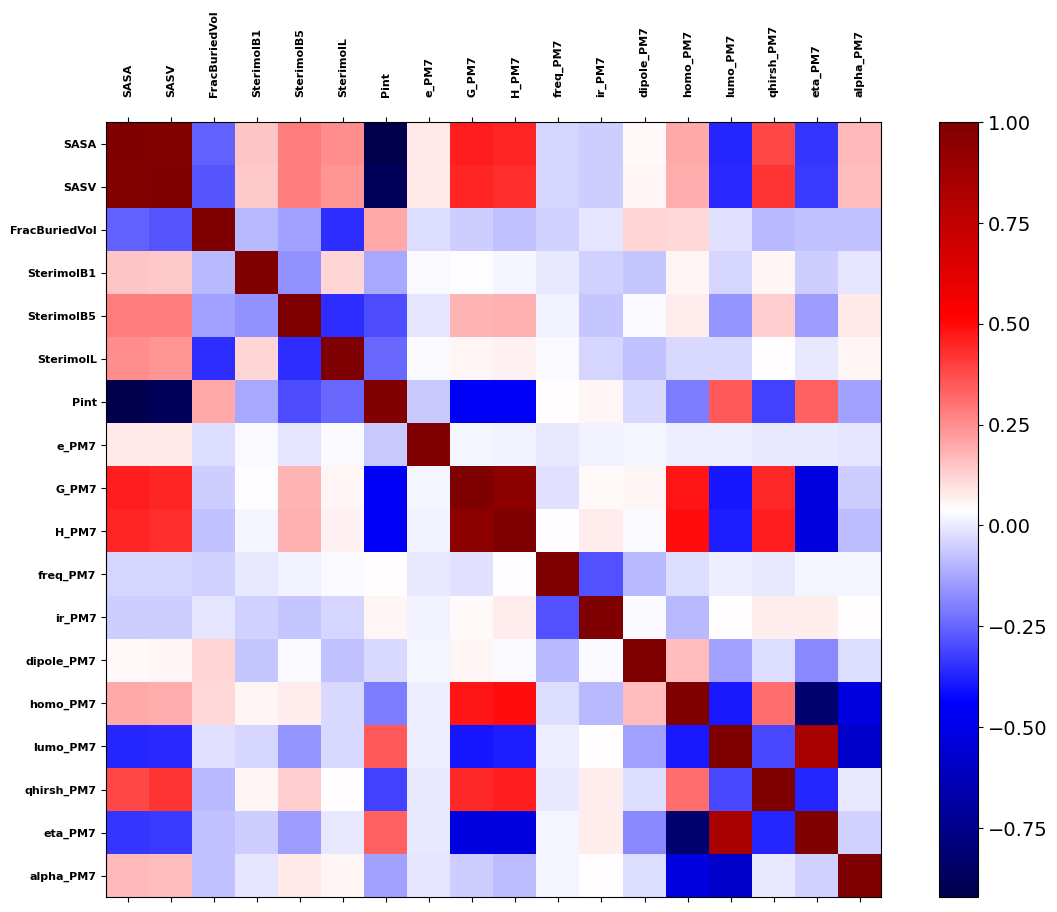

In [17]:
# Draw the heatmap with the mask and correct aspect ratio
corr = X.corr() # Calculate pairwise correlation among descriptors
f = plt.figure(figsize=(15,10))
plt.matshow(corr, fignum=f.number , cmap = plt.cm.seismic)
#plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=30, rotation=90)
plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=8, weight='bold', rotation=90)
plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=8, weight='bold')
plt.tick_params(axis='x', pad=15)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=28)
#plt.savefig("correlation_matrix.png")

Text(0.5, 0, 'Feature')

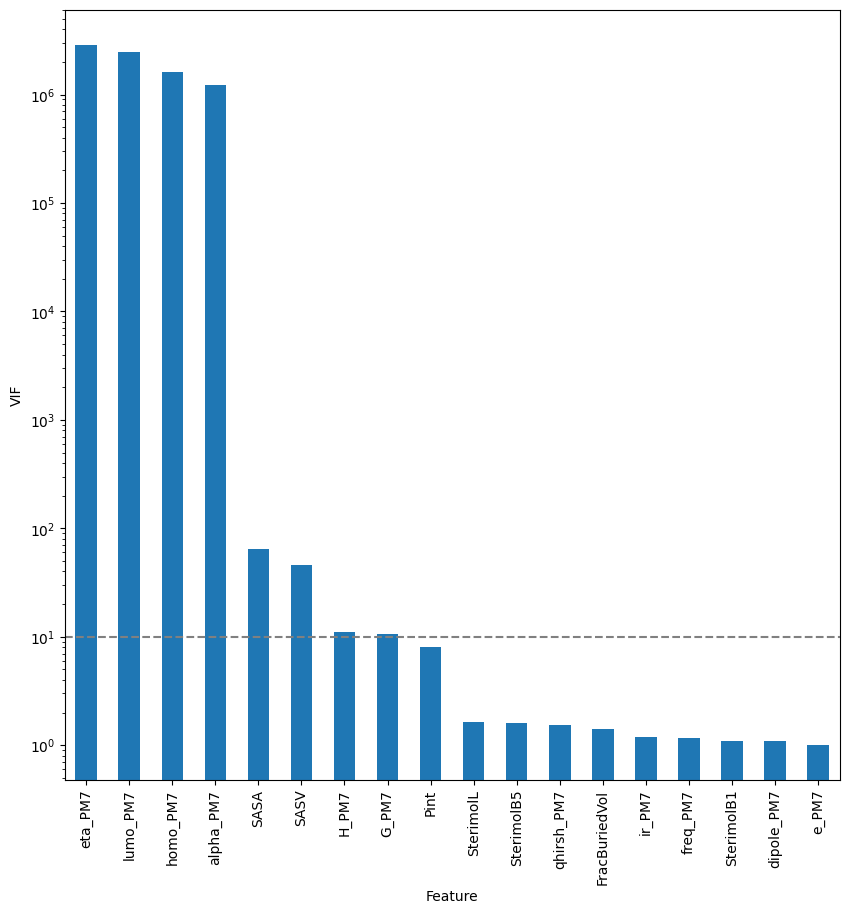

In [22]:
# Feature importance
plt.figure(figsize=(10, 10))
vifs = pd.Series(np.linalg.inv(X.corr("pearson")).diagonal(), index=X.columns, name="VIF")
vifs.sort_values(ascending=False).plot.bar()
plt.yscale("log")
plt.axhline(10, linestyle="--", color="gray")
plt.ylabel("VIF")
plt.xlabel("Feature")

In [18]:
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, PassiveAggressiveRegressor, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor

from warnings import simplefilter, filterwarnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
simplefilter('ignore', category=ConvergenceWarning)
#simplefilter('ignore', category=DataConversionWarning)
filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model._ridge')

from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

In [19]:
def fit_and_evaluate(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test):
    y_train = yref_train.values.ravel()
    y_test = yref_test.values.ravel()
    #y_train = ydiff_train.values.ravel()
    #y_test = ydiff_test.values.ravel()
    print(f"Fitting {model_name}...")
    if model_name == 'CatBoostRegressor':
        model = model_class(verbose=0)
    elif model_name == 'GaussianProcessRegressor':
        #kernel=ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
        kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
        alpha = 10.0
        model = model_class(kernel=kernel, alpha=alpha)
    else:
        model = model_class()
    model.fit(X_train, y_train)
    #joblib.dump(model, f'{model_name}_model.pkl')
    print(f"Model fitting complete for {model_name}.")
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"{model_name} Model Performance for ml:")
    print(f'Train set: R2= {train_r2}, MAE = {train_mae}, RMSE = {train_rmse}')
    print(f'Test set: R2 = {test_r2}, MAE = {test_mae}, RMSE = {test_rmse}')

    #y_train = yref_train.values.ravel()
    #y_test = yref_test.values.ravel()
    #ysqm_train = ysqm_train.values.ravel()
    #ysqm_test = ysqm_test.values.ravel()
    #y_train_pred = ysqm_train + model.predict(X_train)
    #y_test_pred = ysqm_test + model.predict(X_test)
    #train_method_r2 = r2_score(y_train, ysqm_train)
    #test_method_r2 = r2_score(y_test, ysqm_test)
    #train_r2 = r2_score(y_train, y_train_pred)
    #test_r2 = r2_score(y_test, y_test_pred)
    #train_method_mae = mean_absolute_error(y_train, ysqm_train)
    #test_method_mae = mean_absolute_error(y_test, ysqm_test)
    #train_mae = mean_absolute_error(y_train, y_train_pred)
    #test_mae = mean_absolute_error(y_test, y_test_pred)
    #train_method_rmse = np.sqrt(mean_squared_error(y_train, ysqm_train))
    #test_method_rmse = np.sqrt(mean_squared_error(y_test, ysqm_test))
    #train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    #test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #print(f"Performance for PM7:")
    #print(f'Train set: R2= {train_method_r2}, MAE = {train_method_mae}, RMSE = {train_method_rmse}')
    #print(f'Test set: R2 = {test_method_r2}, MAE = {test_method_mae}, RMSE = {test_method_rmse}')
    #print(f"{model_name} Model Performance for ysqm+ml:")
    #print(f'Train set: R2= {train_r2}, MAE = {train_mae}, RMSE = {train_rmse}')
    #print(f'Test set: R2 = {test_r2}, MAE = {test_mae}, RMSE = {test_rmse}')
    
    return model

def run_grid_search(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test):
    y_train = yref_train.values.ravel()
    y_test = yref_test.values.ravel()
    #y_train = ydiff_train.values.ravel()
    #y_test = ydiff_test.values.ravel()
    param_grid = regressor_configs[model_name]
    print(f'Starting GridSearchCV for {model_name}...')
    if model_name == 'CatBoostRegressor':
        model = model_class(logging_level='silent')
    else:
        model = model_class()
    grid_search = GridSearchCV(model_class(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
   
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    #joblib.dump(best_model, f'{model_name}_model.pkl')
    return grid_search, best_model

def print_results(model_name, best_model, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test):
    y_train = yref_train.values.ravel()
    y_test = yref_test.values.ravel()
    print(f"GridSearchCV complete for {model_name}.")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score (MAE): {-grid_search.best_score_}")
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    #y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
    #y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    #y_train = y_scaler.inverse_transform(y_train)
    #y_test = y_scaler.inverse_transform(y_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'{model_name} Model Performance:')
    print(f'Train set: R2= {train_r2}, MAE = {train_mae}, RMSE = {train_rmse}')
    print(f'Test set: R2 = {test_r2}, MAE = {test_mae}, RMSE = {test_rmse}')
    return y_train, y_train_pred, y_test, y_test_pred

def display_results(y_train, y_train_pred, y_test, y_test_pred):
    sns.set_style("white")
    plt.figure(figsize= (5,5))
    plt.xlabel("DFT Barrier Height $(kcal/mol)$" , fontsize = 14)
    plt.ylabel("ML Barrier Height $(kcal/mol)$" , fontsize = 14)
    plt.plot(y_train , y_train_pred , 'o' , color = "red" , markersize = 1 )
    plt.plot(y_test , y_test_pred , 'x' , color = "blue" , markersize = 1 )
    plt.legend(fontsize=14)
    plt.tight_layout()
    #plt.savefig(f"{model_name}_plot.png",bbox_inches='tight')
    return

In [20]:
regressor_configs = {
    'Ridge': {
        'alpha': [1e-1, 1, 10, 50],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'ElasticNet': {
        'alpha': [1e-1, 1, 10, 50],
        'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
        'selection': ['cyclic', 'random']
    },
    'BayesianRidge': {
        'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3]
    },
    'PassiveAggressiveRegressor': {
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        'epsilon': [0, 0.25, 0.5, 0.75, 1]
    },
    'HuberRegressor': {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        'epsilon': [1.35, 1.5, 1.75, 2]
    },
    'KNeighborsRegressor': {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'RandomForestRegressor': {
        #'n_estimators': [10, 50, 100, 200, 500, 1000],
        'max_depth': [1, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        #'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-3, 1e-2, 1e-1, 1],
        'max_depth': [1, 3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'ExtraTreesRegressor': {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'max_depth': [1, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
       'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoostRegressor': {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
        'loss': ['linear', 'square', 'exponential']
    },
    'DecisionTreeRegressor': {
        'max_depth': [1, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    'SVR': {
        'C': [1e-1, 1, 5, 10],
        'epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['auto', 'scale'],
        'degree': [2, 3, 4],
        'coef0': [0, 0.5, 1]
    },
    'KernelRidge': {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        'kernel': ['linear', 'rbf', 'laplacian', 'polynomial', 'sigmoid'],
        #'gamma': ['auto', 'scale'],
        #'degree': [2, 3, 4],
        #'coef0': [0, 0.5, 1]
    },
    'GaussianProcessRegressor': {
        'alpha': [1, 10, 20],
        #'n_restarts_optimizer': [10, 20, 50],
        'kernel': [
            1.0 * RBF(length_scale=1.0),
            1.0 * Matern(length_scale=1.0, nu=1.5),
            1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
            1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0),
            1.0 * DotProduct(sigma_0=1.0) + WhiteKernel(noise_level=1.0),
            ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)            
        ],
    },
    'XGBRegressor': {
        #'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-3, 1e-2, 1e-1, 1],
        'max_depth': [1, 3, 5, 7, 9],
        'subsample': [0.5, 0.75, 1.0],
        'colsample_bytree': [0.5, 0.75, 1.0],
        'min_child_weight': [1, 5, 10]
    },
    'LGBMRegressor': {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_depth': [1, 3, 5, 7, 9],
        'num_leaves': [31, 63, 127],
        'feature_fraction': [0.5, 0.75, 1.0],
        'bagging_fraction': [0.5, 0.75, 1.0]
    },
    'CatBoostRegressor': {
        #'iterations': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-2, 1e-1],
        #'depth': [1, 3, 5, 7, 9],
        #'l2_leaf_reg': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        #'border_count': [32, 64, 128]
    },
    'NGBRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
        'minibatch_frac': [0.5, 0.75, 1.0],
        'natural_gradient': [True, False]
    }
}

models = {
    #'Ridge': Ridge,
    #'ElasticNet': ElasticNet, #Select
    #'BayesianRidge': BayesianRidge,
    #'PassiveAggressiveRegressor': PassiveAggressiveRegressor,
    #'HuberRegressor': HuberRegressor,
    #'KNeighborsRegressor': KNeighborsRegressor,
    'RandomForestRegressor': RandomForestRegressor, #Select
    #'GradientBoostingRegressor': GradientBoostingRegressor,#Select
    #'ExtraTreesRegressor': ExtraTreesRegressor,
    #'AdaBoostRegressor': AdaBoostRegressor,
    #'DecisionTreeRegressor': DecisionTreeRegressor,
    #'SVR': SVR, #Select
    #'KernelRidge': KernelRidge,
    #'GaussianProcessRegressor': GaussianProcessRegressor, #select
    #'XGBRegressor': XGBRegressor, #Select
    #'LGBMRegressor': LGBMRegressor, 
    #'CatBoostRegressor': CatBoostRegressor,
    #'NGBRegressor': NGBRegressor
}

In [21]:
for model_name, model_class in models.items():
    best_model = fit_and_evaluate(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test)
    #grid_search, best_model = run_grid_search(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test)
    #y_train, y_train_pred, y_test, y_test_pred = print_results(model_name, best_model, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test)
    #display_results(y_train, y_train_pred, y_test, y_test_pred)

Fitting RandomForestRegressor...
Model fitting complete for RandomForestRegressor.
RandomForestRegressor Model Performance for ml:
Train set: R2= 0.9601163635058767, MAE = 1.0139121657754007, RMSE = 1.3422461152350686
Test set: R2 = 0.6979634822708968, MAE = 2.550694680851064, RMSE = 3.4368798391452975


In [27]:
# Plot learning curves
from sklearn.model_selection import learning_curve
def plot_learning_curve(model_name, model_calss, X, y, title, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    param_grid = regressor_configs[model_name]
    plt.figure()
    plt.title(title)
    plt.xlabel("Number of training datapoints")
    plt.ylabel("Mean absolute errors (kcal/mol)")
    #train_sizes, train_scores, test_scores = learning_curve(model_class(), X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_sizes, train_scores, test_scores = learning_curve(model_class(), X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

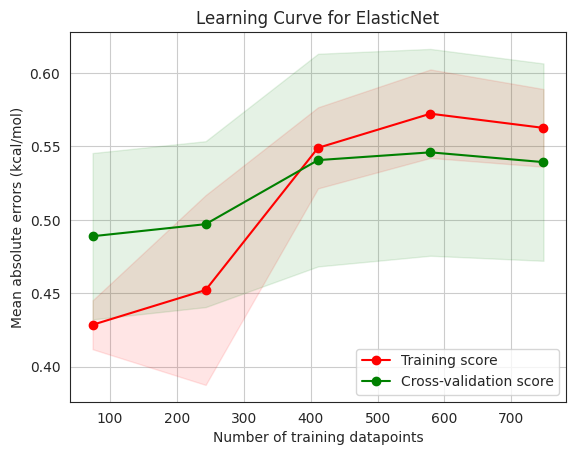

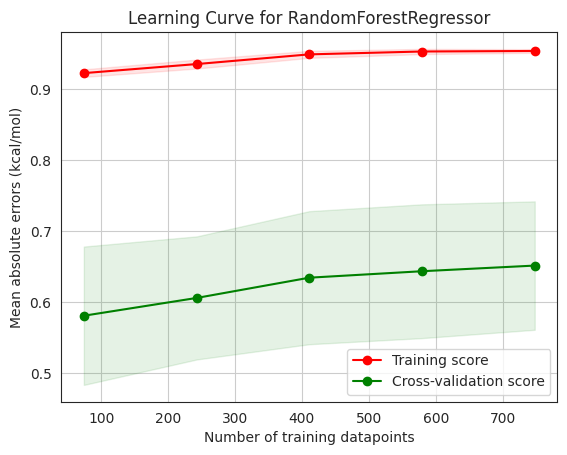

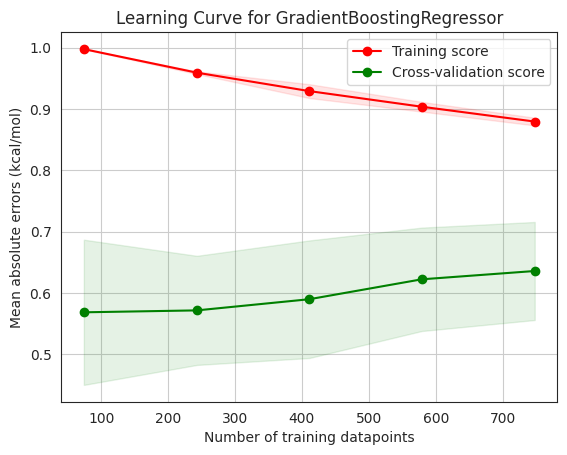

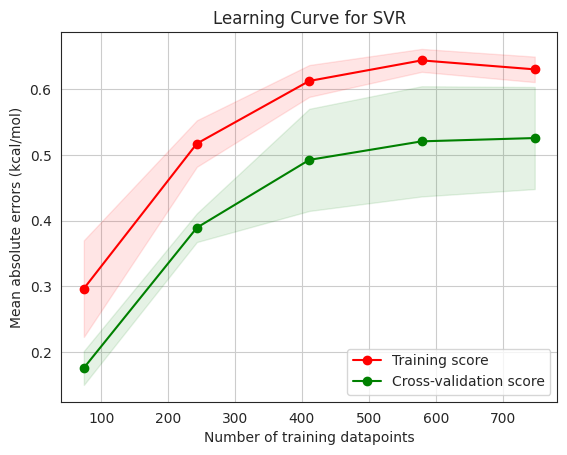

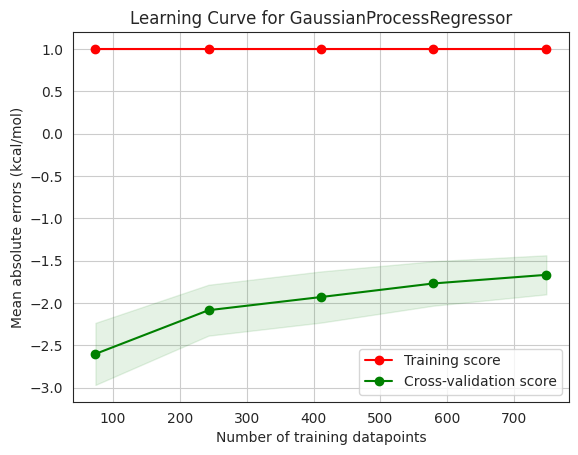

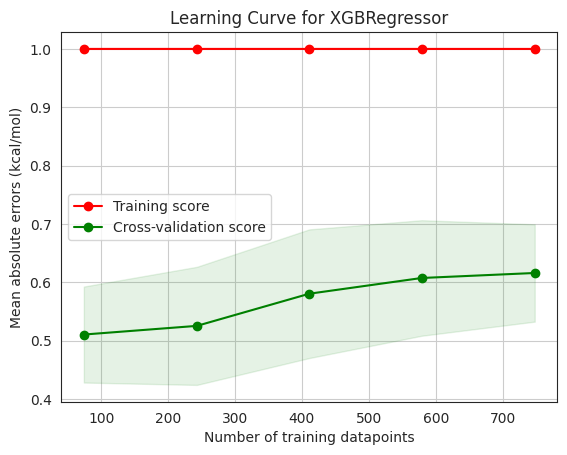

In [28]:
# Learning curves
for model_name, model_class in models.items():
    plot_learning_curve(model_name, model_class, X, y_ref['dGTSR_refDZ'].values.ravel(), f"Learning Curve for {model_name}", cv=5, n_jobs=-1)

In [ ]:
# Y-scrambling test
for scoring_function in scoring_functions:
    print(scoring_function.name)
    true_score, permutation_scores, p_value = permutation_test_score(best_estimator, X, y, cv=cv_folds, n_permutations=10, scoring=make_scorer(scoring_function.function), random_state=1)
    permutation_score_avg = np.mean(permutation_scores)
    print("True score:", true_score)
    print("Permutation score average:", permutation_score_avg)